# Sending a ramp pulse through a 3 cavity-2 qubit system, <mark>with and without thermal losses</mark> 

1. **Introduction**
2. **Problem parameters**
3. **Setting up operators, Hamiltonian's, and the initial state**
4. **Generating a pulse wave**
    * No thermal losses considered
5. **Results**
    * Final state, Fidelity, Concurrence

**Author** : Soumya Shreeram (shreeramsoumya@gmail.com)<br>
**Supervisor** : Yu-Chin Chao (ychao@fnal.gov) <br>
**Date**: 22nd July 2019<br>

This script was coded as part of the Helen Edwards Summer Internship program at Fermilab.

## 1. Introduction

A multi-mode QED architecture is explored as described in by [McKay et *al*](http://schusterlab.uchicago.edu/static/pdfs/McKay2015.pdf). The hamiltonian for such a system with two qubits with frequencies $v_{Q,1}$, $v_{Q,2}$, and $n$ mode filter can be described as the sum of the qubit Hamiltonian, $\hat{H}_Q$, the filter Hamiltonian, $\hat{H}_F$, and the qubit-filter coupling Hamiltonian, $\hat{H}_{Q-F},$
$$ \hat{H} = \hat{H_Q} + \hat{H_F} + \hat{H}_{Q-F} $$

$$ \hat{H_Q} = h\ v_{Q,1}\ \frac{\hat{ \sigma}^z_1}{2} + h\ v_{Q,2}\ \frac{\hat{ \sigma}^z_2}{2}$$

$$ \hat{H}_{F} = \sum_{i=1}^{n}h\ v_{F}\ \hat{a}^{\dagger}_i \hat{a}_i +  \sum_{i=2}^{n}h\ g_{F}\ (\hat{a}^{\dagger}_i \hat{a}_{i-1} + \hat{a}^{\dagger}_{i-1} \hat{a}_i)$$

$$ \hat{H}_{Q-F} = h\ g_{Q1,F}\ (\hat{a}^{\dagger}_1 \hat{\sigma}^-_1 + \hat{a}_1 \hat{\sigma}^+_1) + h\ g_{Q2,F}\ (\hat{a}^{\dagger}_n \hat{\sigma}^-_2 + \hat{a}_n \hat{\sigma}^+_2)$$

where $\hat{\sigma}^{+(-)}$ is the raising and lowering operator for the qubit, $\hat{a}_i$ creates a photon in the $i^{th}$ resonantor, $g_F$ is the filter-filter coupling, and $g_{Q,F}$ is the qubit-filter coupling.

Here we must also account for the interaction of the quantum state with it's environment. This can be represented by a non-Hermitian term in the Hamiltonian such that,
$$\displaystyle H_{\rm eff}(t) = H(t) - \frac{i\hbar}{2}\sum_n c_n^\dagger c_n$$
where $c_n$ is the collapse operator

The code calculates the occupation probability for a system when a ramp pulse is genrated at the qubit 1 resonance frequency.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
plt.rcParams.update({'font.size': 16})

import numpy as np
from numpy import ones,vstack
from numpy.linalg import lstsq
from math import pi

from time import sleep
import sys

from qutip import *

## 2. Problem parameters
Here we use $\hbar=1$; the coupling terms are redefined with a multiple of $2\pi$ before them for convinience.

In [4]:
def generateTimePulse(tr, th):
    """
    Function that generates the pulse based on the input parameters
    @param tr :: ramp up/down time for the pulse
    @param th :: hold time for the pulse
    @return t_pulse :: np array with 4 times that define the pulse
    """
    t_pulse = [0, 0, 0, 0]
    t_pulse[0] = 0
    t_pulse[1] = tr + t_pulse[0]
    t_pulse[2] = t_pulse[1] + th
    t_pulse[3] = t_pulse[2] + tr
    print("The time pulse is: ", t_pulse)
    return t_pulse

In [5]:
"""------------- FREQUENCIES -----------------"""
w_q1 = 2*pi*6.5;     # Qubit 1 frequency
w_q2 = 2*pi*6.8;     # Qubit 2 frequency: range from 1-9 GHz
w_f = 2*pi*7.1;      # Resonator/ Filter frequency

# from notebook on 3 cavities we saw that cavity splits into 3 levels
w_f1 = 2*pi*6.933
w_f2 = 2*pi*7.1
w_f3 = 2*pi*7.2668
"""------------- COUPLING --------------------"""
g_f1 = 2*pi*0.118    # Filter-filter coupling
g_f2 = 2*pi*0.344 
g_q1f = 2*pi*0.135   # qubit 1-fitler coupling
g_q2f = 2*pi*0.415   # qubit 2-fitler coupling

numF = 3             # number of filters
N = 2                # number of fock states 
times = np.linspace(0,200,1000)

"""------------- DISSIPATION PARAMETERS -----"""
kappa = 0.05         # cavity dissipation rate
n_th_a = 0.003       # avg. no. of thermal bath excitation
r1 = 0.005           # qubit relaxation rate
r2 = 0.015           # qubit dephasing rate

"""------------- PULSE CONTROL PARAMETERS -----"""
tr = 10              # ramp up and ramp down times
th = 90              # hold time
t_pulse = generateTimePulse(tr, th)

# amplitude to raise pulse above cavity frequency (optional)
d = 0.25
w_top = w_f + 2*pi*d
no_ramps = 100        # number of ramps pulses sent into the Hamiltonian

The time pulse is:  [0, 10, 100, 110]


## 3. Setting up the operators, Hamiltonian's, and Initial state

For every qubit: <br> <br>
**sm** $\ \rightarrow \ \hat{\sigma}^{+(-)}$ is the raising and lowering operator of the *qubit* <br>
**sz** $\ \ \rightarrow \ \sigma_z $ is the Pauli-z matrix of the *qubit* <br>
**n** $\ \ \ \rightarrow \ n$ is the number operator

In [6]:
def numOp(m):
  """
  Computes the number operator 
  @param loweringMat :: lowering matrix operator for a system
  """
  return m.dag()*m

def rwaCoupling(m1, m2):
    return m1.dag()*m2 + m1*m2.dag()

def setXYlabel(ax, x, y, req_title, title_):
    """
    Generic function to set labels for plots
    """
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    if req_title == True:
        ax.set_title(title_)
    return 

### 3.1 Operators 

In [7]:
# cavity 1, 2, 3 destruction operators
a1 = tensor(destroy(N), qeye(N), qeye(N), qeye(2), qeye(2))
a2 = tensor(qeye(N), destroy(N), qeye(N), qeye(2), qeye(2))
a3 = tensor(qeye(N), qeye(N), destroy(N), qeye(2), qeye(2))

# operators for qubit 1 
sm1 = tensor(qeye(N), qeye(N), qeye(N), sigmam(), qeye(2))
sz1 = tensor(qeye(N), qeye(N), qeye(N), sigmaz(), qeye(2))    
n1 = sm1.dag() * sm1

# operators for qubit 2
sm2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmam())
sz2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2

In [8]:
# collapse operators
c_ops = []

# cavity relaxation
rate = kappa * (1 + n_th_a)
c_ops.append(np.sqrt(rate) * a1)
    
# cavity excitation

# qubit 1 relaxation
c_ops.append(np.sqrt(r1 * (1+n_th_a)) * sm1)
c_ops.append(np.sqrt(r1 * n_th_a) * sm1.dag())
c_ops.append(np.sqrt(r2) * sz1)

# qubit 2 relaxation
c_ops.append(np.sqrt(r1 * (1+n_th_a)) * sm2)
c_ops.append(np.sqrt(r1 * n_th_a) * sm2.dag())
c_ops.append(np.sqrt(r2) * sz2)

### 3.2 Hamiltonian's and initial state

In [9]:
# Qubit Hamiltonians (Hq1+Hq2)
Hq1 =  0.5*sz1       
Hq2 =  0.5*sz2

# Filter Hamiltonians (refer formula in the Introduction)
Hf = numOp(a1) + numOp(a2) + numOp(a3)    
H_f12 = g_f1*(rwaCoupling(a1, a2) + rwaCoupling(a2, a3))

# Qubit-Filter Hamiltonian
Hqf = g_q1f*(rwaCoupling(a1, sm1) + rwaCoupling(a3, sm2))

# time-independent Hamiltonian (see later)
H0 = H_f12 + Hqf + w_f*Hf + w_q2*Hq2
 
H = H0 + w_q1*Hq1  # Resultant Hamiltonian

### 3.3 Initial State

In [10]:
# initial state of the system. Qubit 1: excited, Qubit 2: ground st.
psi0 = tensor(basis(N,0), basis(N,0), basis(N,0), basis(2,0), basis(2,1))

## 4. Demonstrating avoided crossing

In this section the qubit frequency is raised above the cavity frequency by applying a linearly varying ramp time $t$ (ns). The signal is held for a time $T-2t$ before it is ramped down again. 

Tranformations on closed quantum states can be modelled by unitary operators. The combined time-dependent Hamiltonian for a system undergoing a tranformation that can be representated as,
$$ H(t) = H_0 + \sum_{i=0}^n c_i(t)H_i$$
where $H_0$ is called the time-independent drift Hamiltonian and $H_i$ are the control Hamiltonians with a time varying amplitude $c_i(t)$.

Here we write the Hamiltonian in a function-based time dependent way. See other ways [here](http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html). Here the time-dependent coefficients, $f_n(t)$ of the Hamiltonian (e.g. `wf_t, w1_t,w2_t`) are expressed using Python functions 

### 4.1 Functions

In [11]:
"""----------------------------------------
                  PULSE FUNCTIONS
------------------------------------------"""
def fitLine(t_pulse, i, j, w1, w2, t):
    """
    Function generates a best fit line between [x1, y1] ->[x2, y2]
    Input:
        @param t_pulse :: np array containing the 4 points parameterizing the pulse
        @param i,j :: indicies of t_pulse determining the start-stop times
        @param w1, w2 :: lower and higher frequencies of the ramp pulse
        @param t :: interable time variable
    Returns:
        @polynomial(t) :: best-fit y value at t
    """
    # compute coefficients
    coefficients = np.polyfit([t_pulse[i], t_pulse[j]], [w1, w2], 1) 
    # generate best-fit polynmial
    polynomial = np.poly1d(coefficients)    
    return polynomial(t)

def rampUp(t_pulse, w1, w2, t):
    """
    Generating a ramp up pulse
    Input:
        @param t_pulse :: np array containing the 4 points parameterizing the pulse
        @param w1, w2 :: lower and higher frequencies of the ramp pulse
        @param t :: interable time variable
    Returns:
        @param w :: int giving the y-value based on t
    """
    t0 = t_pulse[0]
    t1 = t_pulse[1]
    if t0 != t1:
        if t < t1:
            return w1 + fitLine(t_pulse, 0, 1, 0, (w2-w1), t)*(t>t0) 
        if t > t1:
            return w1 + (w2-w1)*(t>t1)
    else:
        return w1 + (w2 - w1)*(t > t1)

def rampDown(t_pulse, w1, w2, t):
    """
    Generating a ramp Down pulse
    Same as the ramp Up pulse given above only with the 
    """
    t2 = t_pulse[2]
    t3 = t_pulse[3]
    if t2 != t3:
        if t > t2:
            return w1 + fitLine(t_pulse, 2, 3, (w2-w1), 0, t)*(t>t2 and t<t3) 
        if t < t2:
            return w1 + (w2-w1)*(t<t2)
    else:
        return w1 + (w2-w1)*(t<t2)

def wq1_t(t, args=None):
    """
    Function defines the time depended co-efficent of the qubit 1
    w_q1(t) is a pulse wave going from 0 to height (w_f-w_q1) at T0_1 
    """
    return (rampUp(t_pulse, w_q1, w_top, t) + rampDown(t_pulse, w_q1, w_top, t)-w_top)

def wq1_tdown(t, args=None):
    """
    Function defines the time depended co-efficent of the qubit 1
    w_q1(t) is a pulse wave going from 0 to height (w_f-w_q1) at T0_1 
    """
    return rampDown(t_pulse, w_q1, w_top, t)

def wf_t(t, args=None):
    """
    Function defines the time depended co-efficent of the filters
    (Although, there is no frequency change of the filters with time)
    so w_f(t) = constant
    """
    return w_f


def wq2_t(t, args=None):
    """
    Function defines the time depended co-efficent of qubit 2
    (Although, there is no frequency change of the quibit 2 with time)
    so w_q2(t) = constant
    """
    return w_q2

"""---------------------------------------------
                  HAMILTONIAN FUNCTIONS
---------------------------------------------"""
def plotPulse(ax, times, t_pulse, w_q1, w_top, colorCode, label_, ramp):
    """
    Plots the required pulse
    """
    if ramp == True:
        plotting = ax.plot(times, [rampUp(t_pulse, w_q1, w_top, t)/(2*pi) for t in times], colorCode, label=label_)
    elif ramp == False:
        plotting = ax.plot(times, [rampDown(t_pulse, w_q1, w_top, t)/(2*pi) for t in times], colorCode, label=label_)
    if ramp == 'Custom':
        plotting = ax.plot(times, [(rampUp(t_pulse, w_q1, w_top, t) + rampDown(t_pulse, w_q1, w_top, t)-w_top)/(2*pi) for t in times], colorCode, label=r"$\Delta$t = %.1f ns"%(t_pulse[1]-t_pulse[0]))
    return plotting

def labelTimes(t_r, t_H):
    return r"$\Delta t = %.2f {\ \rm ns}, t_{\rm H} = %.2f {\ \rm ns}$"%(t_r, t_H)    

def wf1_t(t, args=None):
    return w_f1
def wf2_t(t, args=None):
    return w_f2
def wf3_t(t, args=None):
    return w_f3

def plotFrequencies(ax, times, wf_t, Colour, labels_, linestyle_):
    """
    Function plots the frequencies as a function of times
    """
    ax.plot(times, np.array(list(map(wf_t, times)))/(2*pi), Colour, linewidth=2, label=labels_, linestyle=linestyle_)
    ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    return 
    
def setLabels(ax, tr, th, plot_no):
    """
    Function sets the labels of the x-y axis in the plot below
    """
    if plot_no == 0:
        ax.set_ylabel("Frequency (GHz)", fontsize=16)
        ax.set_title(labelTimes(tr, th))
    else:
        ax.set_xlabel("Time (ns)")
        ax.set_ylabel("Occupation \n probability")
    return 

def plotProb(ax, times, component, res, Colour, labels_, linestyle_):
    """
    Function plots the occupation probabilities of the components after running mesolve
    """
    ax.plot(times, np.real(expect(component, res.states)), Colour, linewidth=1.5, label=labels_, linestyle=linestyle_)
    ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    return 

### 4.2 Demonstrating the ramp pulse generated

The figure below demonstrated how the combination of ramping up and down forms the required pulse. 

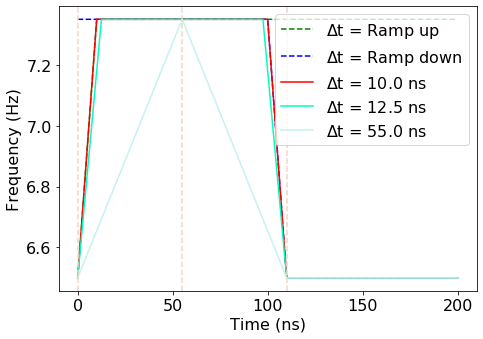

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

t_pulse1 = [t_pulse[0], t_pulse[1]+2.5, t_pulse[2]-2.5, t_pulse[3]]
t_pulse2 = [t_pulse[0], (t_pulse[3]-t_pulse[0])/2+t_pulse[0], (t_pulse[3]-t_pulse[0])/2+t_pulse[0], t_pulse[3]]

# plotting the pulses
plotPulse(ax, times, t_pulse, w_q1, w_top, 'g--', r"$\Delta$t = Ramp up", True)
plotPulse(ax, times, t_pulse, w_q1, w_top, 'b--', r"$\Delta$t = Ramp down", False)
plotPulse(ax, times, t_pulse, w_q1, w_top, 'r', ' ', 'Custom')
plotPulse(ax, times, t_pulse1, w_q1, w_top, '#03fcba', ' ', 'Custom')
plotPulse(ax, times, t_pulse2, w_q1, w_top, '#c4f2f1', ' ', 'Custom')

# guide lines
ax.axvline(x=t_pulse[0], color='#f2d4c4', linestyle='--')
ax.axvline(x=t_pulse[3], color='#f2d4c4', linestyle='--')
ax.axvline(x=t_pulse2[2], color='#f2d4c4', linestyle='--')

setXYlabel(ax, 'Time (ns)', 'Frequency (Hz)', False, '')
ax.legend(loc="upper right")
fig.tight_layout()

### 4.2 Solving the Master equation and plotting the results (without thermal losses)

In [13]:
opts = Odeoptions(max_step=0.0005, nsteps=50000)

# time dependent Hamiltonian
H_t = [H0, [Hq1, wq1_t]]

# Evolving the system
res1 = mesolve(H_t, psi0, times, [], [])

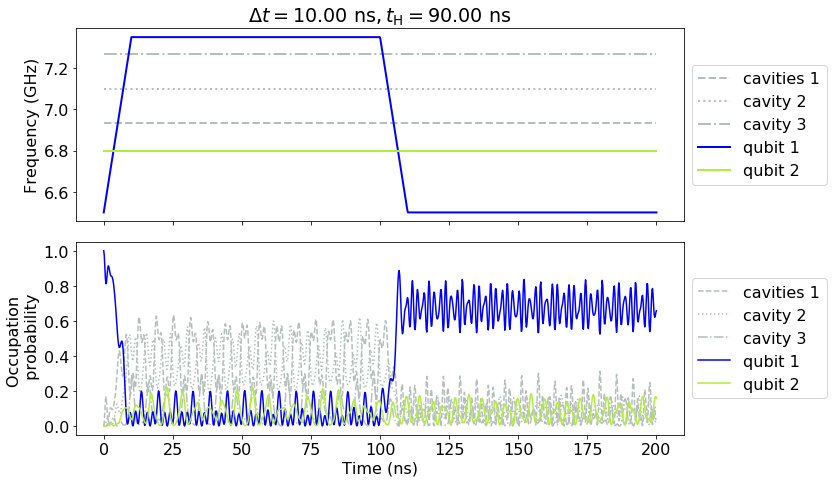

In [14]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,7))

labels_ = ["cavities 1", "cavity 2", "cavity 3", "qubit 1", "qubit 2"]
w_list = [wf1_t, wf2_t, wf3_t, wq1_t, wq2_t]
colors_ = ['#b4bfbc', '#b4bfbc', '#b4bfbc', 'b', '#b0ed3e']
linestyle_ = ['--', ':', '-.', '-', '-']
components_ = [numOp(a1), numOp(a2), numOp(a3), n1, n2]

for i in [0, 1, 2, 3, 4]:
    plotFrequencies(axes[0], times, w_list[i], colors_[i], labels_[i], linestyle_[i])
setLabels(axes[0], tr, th, 0)

for i in [0, 1, 2, 3, 4]:
    plotProb(axes[1], times, components_[i], res1, colors_[i], labels_[i], linestyle_[i])
setLabels(axes[1], tr, th, 1)

fig.tight_layout()

## 5. Studying the effect of various ramp times on avoided crossing

In [15]:
def showProgress(idx, n):
    """
    Function prints the progress bar for a running function
    @param idx :: iterating index
    @param n :: total number of iterating variables/ total length
    """
    j = (idx+1)/n
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()
    sleep(0.25)
    return 

def findIndex(times, t4):
    """
    Function finds the index in the times array at required point t4
    @param times :: np array contains the times at which H is evaluated
    @param t4 :: the point at which the pulse ends
    @returns param idx_array[0] :: the index of t4 in the times array
    """
    idx_array = []
    for i, t in enumerate(times):
        if t >= t4 and t < t4+1:
            idx_array.append(i)
    return idx_array[0]

def genTimePulses(rampList):
    """
    Generates pulses with variable ramp times
    @param rampList :: List with 
    """
    ramp_vals = np.empty((0, 4))
    for dt in rampList:
        t_new = [t_pulse[0], t_pulse[1]+dt, t_pulse[2]-dt, t_pulse[3]]
        ramp_vals = np.append(ramp_vals, [t_new], axis=0)  
    return ramp_vals  

def printShape(ramp_dt_array):
    print("\nDimensions of the resultant 2D array:",   np.shape(ramp_dt_array))
    return 

In [16]:
# get the point after the ramp down excitation
t_idx = findIndex(times, t_pulse[3])

# generating a range of pulse with varying ramp times
rampList = np.linspace(t_pulse[1], (t_pulse[3]-t_pulse[0])/2+t_pulse[0], no_ramps)-t_pulse[1]

# generates the pulses
ramp_vals = genTimePulses(rampList)

### { Case I } No thermal losses: Evaluating the excited state population at <mark>all times</mark> of the pulse. The excited state population is studied for a range of different ramp pulses. 

In [17]:
#ramp_dt_array2D = evaluateHam2D(ramp_vals, True, no_ramps, H0, Hq1, wq1_t)
no_loss = True
exp_vals = []
ramp_dt_array2D = np.empty((0, len(times)))
for i in range(no_ramps):
    t_pulse = ramp_vals[i][:]        

    # time dependent Hamiltonian
    H_t = [H0, [Hq1, wq1_t]]

    # Evolving the system with/without thermal losses
    if no_loss == True:         
        output = mesolve(H_t, psi0, times, [], [])
    else:
        output = mesolve(H_t, psi0, times, c_ops, [])

    exp_vals = np.real(expect(n1, output.states))
    ramp_dt_array2D = np.append(ramp_dt_array2D, [exp_vals], axis=0)

    # progress bar
    showProgress(i, no_ramps)
printShape(ramp_dt_array2D)

[====================] 100%
Dimensions of the resultant 2D array: (100, 1000)


### { Case II } <u>Thermal losses</u>: Evaluating the excited state population at the <mark>end of ramp down</mark> of the pulse. The excited state population is studied for a range of different ramp pulses. 

In [18]:
no_loss = False
exp_valsi = []
ramp_dt_array2Di = np.empty((0, len(times)))
for i in range(no_ramps):
    t_pulse = ramp_vals[i][:]        

    # time dependent Hamiltonian
    H_t = [H0, [Hq1, wq1_t]]

    # Evolving the system with/without thermal losses
    if no_loss == True:         
        output = mesolve(H_t, psi0, times, [], [])
    else:
        output = mesolve(H_t, psi0, times, c_ops, [])

    exp_valsi = np.real(expect(n1, output.states))
    ramp_dt_array2Di = np.append(ramp_dt_array2Di, [exp_valsi], axis=0)

    # progress bar
    showProgress(i, no_ramps)
printShape(ramp_dt_array2Di)

[====================] 100%
Dimensions of the resultant 2D array: (100, 1000)


### 5.1 Plotting the result obtained for different ramp times <mark>without thermal losses</mark>

In [19]:
def plotForVariousRamps(rampList, times, ramp_dt_array2D):
    """
    Plots the variation in the excitation probability as a function of times and ramp up/down times
    @param rampList :: array of times by which the ramp time is increased
    @param times :: array of times at which H is evaluated
    @praem ramp_dt_array2D :: 2D array of occupation probabilities resulting for evaluating at various ramp times
    """
    fig, ax = plt.subplots(2, 1, figsize=(9,10))
    ax[0].plot(rampList, ramp_dt_array2D[:, t_idx],  'k-', marker='o', markerfacecolor='r', linewidth=1)
    setXYlabel(ax[0], r'Ramp times $t$ (ns)', 'Excited population of qubit 1', True, 'Evaluated at t=%.2f, d=%.1f\n'%(times[t_idx],d ))

    Colors_ = ['#4f9bd1', '#4f55d1', '#9d4fd1', '#d14fac']
    for i,j in enumerate([0, 30, 60, 90]):
        ax[1].plot(times, ramp_dt_array2D[j, :], Colors_[i], label=r'$\Delta t =$ %.2f'%rampList[j])
        ax[1].legend()
    setXYlabel(ax[1], 'Times (ns)', 'Excited population of qubit 1', True, 'Occupation probabilty vs times for various ramps\n' )

    fig.tight_layout()
    return 

def plot3Dramps(rampList, times, ramp_dt_array2D):
    """
    3D plot of the variation in the excitation probability as a function of times and ramp up/down times
    @param rampList :: array of times by which the ramp time is increased
    @param times :: array of times at which H is evaluated
    @praem ramp_dt_array2D :: 2D array of occupation probabilities resulting for evaluating at various ramp times
    """
    fig = plt.figure(figsize=(14,10))
    ax = fig.gca(projection='3d')

    X, Y = np.meshgrid(rampList, times)

    surf = ax.plot_surface(X, Y, np.transpose(ramp_dt_array2D), rstride=1, cstride=1, cmap=cm.gist_heat, linewidth=1, antialiased=False)

    #surf2 = ax.plot_wireframe(X, Y, np.transpose(ramp_dt_array2D), rstride=40, cstride=40, color='k', linewidth=0.5)

    # Add a color bar, axis properties
    fig.colorbar(surf, shrink=0.5, aspect=10)
    ax.set_xlabel('\nRamp times' + r'$\ \Delta t$ (ns)')
    ax.set_ylabel('\nTime (ns)')
    ax.set_zlabel('\nOccupation Probabilities');
    ax.set_title(labelTimes(tr, th))
    ax.view_init(16, 25)
    plt.show()
    return

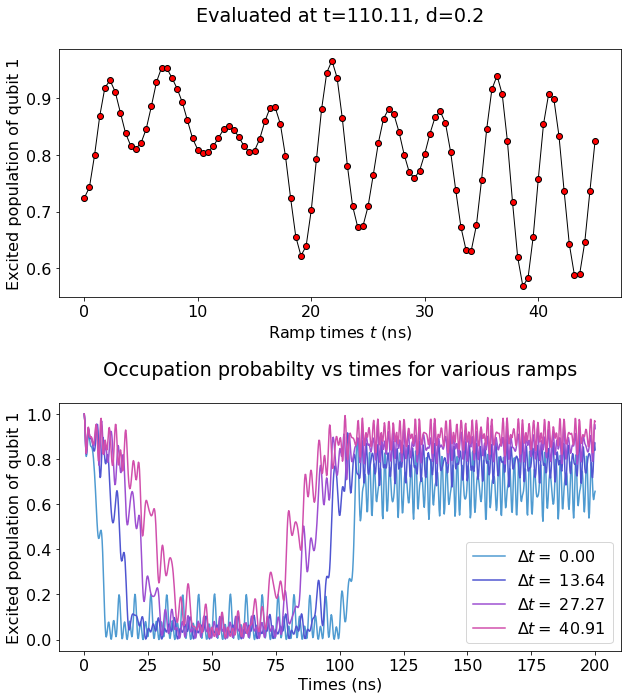

In [20]:
plotForVariousRamps(rampList, times, ramp_dt_array2D)

3D plot summing up the above two plots.

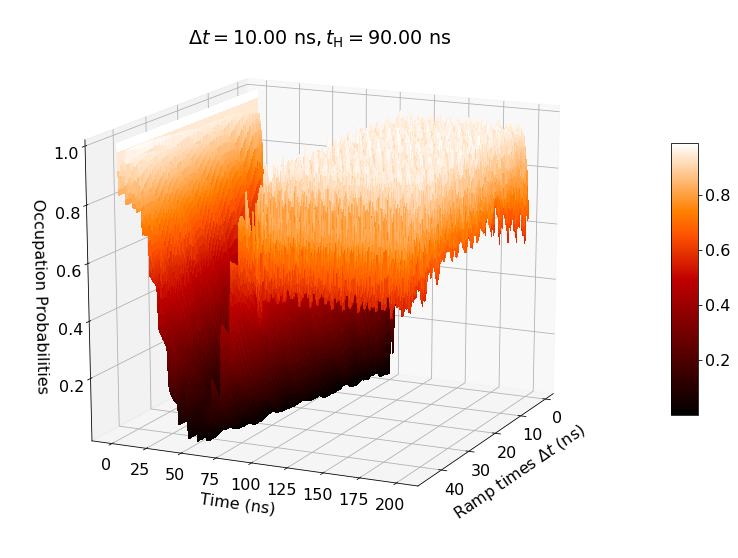

In [21]:
plot3Dramps(rampList, times, ramp_dt_array2D)

### 5.2 Plotting the result obtained for different ramp times <mark>with thermal losses</mark>

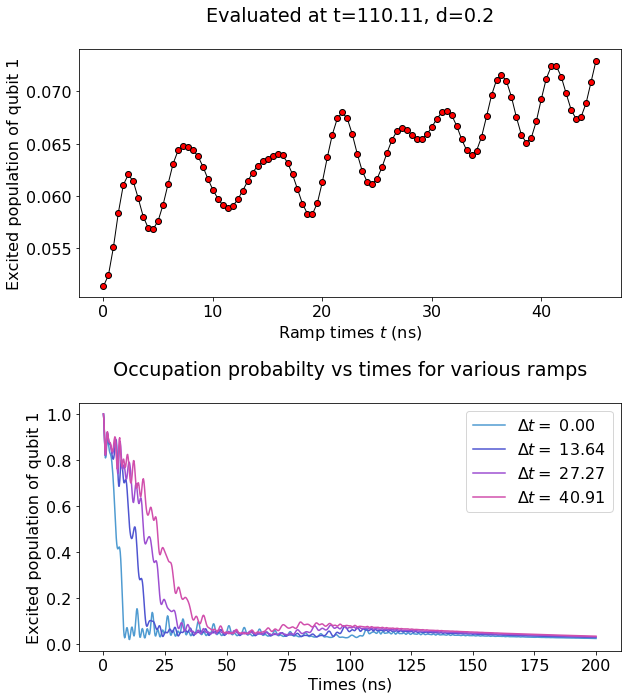

In [22]:
plotForVariousRamps(rampList, times, ramp_dt_array2Di)

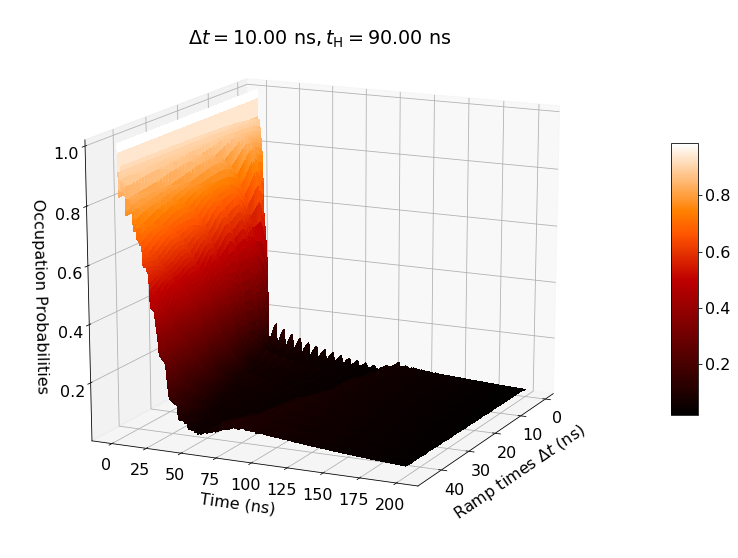

In [23]:
plot3Dramps(rampList, times, ramp_dt_array2Di)

## 6. Calculating the Fidelity and Concurrence

In [24]:
# extract the final state from the result of the simulation
rho_final = res1.states[-1]

# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [1,2])
rho_qubits

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.85288898+0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.02636203+0.j         -0.0493458 +0.02735289j
   0.        +0.j        ]
 [ 0.        +0.j         -0.0493458 -0.02735289j  0.12074899+0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]]

In [25]:
# compare to the ideal result of the sqrtiswap gate (plus phase correction) for the current initial state
rho_qubits_ideal = ket2dm(tensor(phasegate(0), phasegate(-pi/2)) * sqrtiswap() * tensor(basis(2,1), basis(2,0)))
rho_qubits_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.  0. ]]

In [26]:
print('Fidelity = ', fidelity(rho_qubits, rho_qubits_ideal))
print('Concurrence = ', concurrence(rho_qubits))

Fidelity =  0.1555946897609815
Concurrence =  0.11283951087235235
